<a href="https://colab.research.google.com/github/MilanCugur/Neuroevolution-LocalSearch/blob/master/Baseline_Model/Baseline_Neuroevolution_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def extract_dataset(path):
  """
  extract DoubledMNIST dataset
  Argument: path to .zip file with the dataset
  Return value: x_train, y_train, x_test, y_test lists of numpy arrays 
  
  (DoubledMNIST dataset: train size 120k images 56x56, test size 20k images 56x56)
  """
  # import libraries
  import os                     # for basic os operations
  from zipfile import ZipFile 
  from skimage import io
  import numpy as np
  import shutil
  
  if not path.endswith('.zip'):
    raise ValueError("Error: path is not '.zip' file")
  
  archive = ZipFile(path, 'r')  # extract
  archive.extractall('./DoubledMNIST')
  archive.close()
  del archive
  
  x_train = []
  y_train = []
  x_test = []
  y_test = []
  
  for file in os.listdir('./DoubledMNIST/train'):
    img = io.imread(os.path.join('./DoubledMNIST/train', file))
    x_train.append(np.array(img))
    y_train.append(int(file.split('_')[1]))
  
  for file in os.listdir('./DoubledMNIST/test'):
    img = io.imread(os.path.join('./DoubledMNIST/test', file))
    x_test.append(np.array(img))
    y_test.append(int(file.split('_')[1]))
    
  shutil.rmtree('./DoubledMNIST')
  return x_train, y_train, x_test, y_test

In [0]:
%%time
_x_train, _y_train, _x_test, _y_test = extract_dataset('./drive/My Drive/ni_sem/DoubledMNIST.zip')

CPU times: user 1min 4s, sys: 15.5 s, total: 1min 19s
Wall time: 1min 24s


In [0]:
BOX_SIZE = 56

In [0]:
from keras.utils import to_categorical
import numpy as np
y_train = to_categorical(_y_train)[:]
y_test = to_categorical(_y_test)[:]

x_train = np.array(_x_train).astype('float32')[:]
x_train /= 255
x_train = np.reshape(x_train,[-1, BOX_SIZE, BOX_SIZE, 1])

x_test = np.array(_x_test).astype('float32')[:]
x_test /= 255
x_test = np.reshape(x_test, [-1, BOX_SIZE, BOX_SIZE, 1])

In [0]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape #, x_train[0]

((120000, 56, 56, 1), (20000, 56, 56, 1), (120000, 10), (20000, 10))

In [0]:
print(len(x_train))  # size check
print(len(y_train))
print(len(x_test))
print(len(y_test))

120000
120000
20000
20000


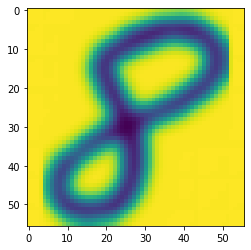

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [0]:
from matplotlib import pyplot as plt  # smal demonstration

plt.imshow(x_test[19].reshape(BOX_SIZE, BOX_SIZE))
plt.show()

print(y_test[19])

# CNN tools

In [0]:
STAGES = np.array(["s1","s2","s3"]) # S
NUM_NODES = np.array([3,4,5])       # K
FILTERS = np.array([32, 48, 64])
sampleIndividual = [1, 0, 1,   1, 1, 0, 1, 0, 0,  1, 0, 1, 0, 0, 1, 0, 0, 0, 1]

# sampleIndividual = [1, 0, 1,   1, 0, 1, 0, 0, 1,  1, 0, 1, 0, 0, 1, 0, 0, 0, 1]; radi klasicna CNN
# stage1 examples
# sampleIndividual = [1, 0, 0,   1, 0, 1, 0, 0, 1,  1, 0, 1, 0, 0, 1, 0, 0, 0, 1]; radi; trojka eliminisana
# sampleIndividual = [0, 1, 0,   1, 0, 1, 0, 0, 1,  1, 0, 1, 0, 0, 1, 0, 0, 0, 1]; radi; dvojka eliminisana
# sampleIndividual = [0, 0, 1,   1, 0, 1, 0, 0, 1,  1, 0, 1, 0, 0, 1, 0, 0, 0, 1]; radi; jedinica eliminisana
# sampleIndividual = [0, 0, 0,   1, 0, 1, 0, 0, 1,  1, 0, 1, 0, 0, 1, 0, 0, 0, 1]; radi; samo jedna konv.
# stage2 examples
# sampleIndividual = [1, 0, 1,   0, 0, 0, 0, 0, 1,  1, 0, 1, 0, 0, 1, 0, 0, 0, 1]; radi 0->3->4->5
# sampleIndividual = [1, 0, 1,   0, 1, 0, 0, 0, 0,  1, 0, 1, 0, 0, 1, 0, 0, 0, 1]; radi 0->1->3->5
# sampleIndividual = [1, 0, 1,   1, 1, 0, 1, 0, 0,  1, 0, 1, 0, 0, 1, 0, 0, 0, 1]; radi; 0->1->2,3,4->5

In [0]:
def __create_indices(num_nodes):
  """
  num_nodes - number of nodes per each stage

  Calculate bits indices (startindex, length) for each stage 
  """
  l =  0                              # genome length
  bits_indices, i = np.empty((0,2),dtype = np.int32), 0 
  for Ks in num_nodes:
    length = Ks * (Ks - 1)
    bits_indices = np.vstack([bits_indices,[i, i + int(0.5 * length)]])
    i += int(0.5 * length)
    l += length
  l = int(0.5 * l)
  return bits_indices, l

def CNN_build(stages, num_nodes, n_filters, individual, box_size, n_classes, verbose=0):
  """
  stages - array of stage names
  num_nodes - number of conv nodes per each stage
  n_filters - number of filters per stage
  individual - binary list representing individual architecture
  box_size - expect input images like (box_size, box_size)
  n_classes - number of output clasees

  Build CNN architecture from the given list
  """
  from keras.models import Model
  from keras.layers import Input, Conv2D, MaxPool2D, Add, Activation, Flatten, Concatenate, Dense, Dropout, BatchNormalization
  from keras.optimizers import Adam  
  from keras.losses import categorical_crossentropy
  from keras.layers import LeakyReLU, concatenate
  from keras.layers.advanced_activations import ReLU
  from keras.initializers import glorot_normal
  import keras.backend as K
  from keras.models import load_model  # Save model params

  L = len(individual)
  bits_indices, _L= __create_indices(num_nodes)
  assert(L==_L)  # small check of the input individual connections info

  if(verbose):
    print('Starting network building..')
  image_shape = (box_size, box_size, 1) 
  x_input = Input(shape=image_shape)  
  previous = None # output from previous stage (initially input of CNN)
  # Build stage by stage
  for i, (s, Ks, n_filter) in enumerate(zip(stages, num_nodes, n_filters)):
    if i==0:
      previous = x_input
    if(verbose):
        print('\nBuild layer', s, ':', Ks, 'nodes,', n_filter, 'filters.')
    stage_indices = individual[bits_indices[i][0]:bits_indices[i][1]]                  # connection indices for current stage nodes; ex. [1, 0, 1, 0, 0, 1, 0, 0, 0, 1]
    stage_indexes = np.split(range(int(Ks*(Ks-1)/2)),np.cumsum(range(Ks - 1)))[1:]     # connection indexes for current stage nodes; ex. [array([0]), array([1, 2]), array([3, 4, 5]), array([6, 7, 8, 9])]
    stage_nodes = []                                                                   # nodes in a stage; ex. [vs1_1, vs1_2, vs1_3] (0, 4 are dummy)
    to_him = list(np.zeros(Ks))                                                              # number of nodes to which i-th node points to
    from_him = list(np.zeros(Ks))  
    if(verbose):                                                          # number of nodes from i-th node to others
        print('Stage indices:', stage_indices)
        print('Stage indexes:', stage_indexes)

    # default stage input node
    if(verbose):
        print('Building '+'v'+str(s)+'_0')
    vs0 = Conv2D(filters=n_filter, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', name='v'+str(s)+'_0')(previous)  # TODO
    if(verbose):
        print('Builded '+'v'+str(s)+'_0')

    # first node and trivial vs0->vs1
    if(verbose):
        print('Building '+'v'+str(s)+'_1')
    vs1 = Conv2D(filters=n_filter, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', name='v'+str(s)+'_1')(vs0) 
    stage_nodes += [vs1]
    if(verbose):
        print('Builded '+'v'+str(s)+'_1')

    for j in range(2, Ks+1):
      name = 'v'+str(s)+'_'+str(j)  # name of the current node
      if(verbose):
        print('Building '+name)
      tonode = stage_indices[stage_indexes[j-2][0]:stage_indexes[j-2][-1]+1]  # slice from stage_indices
      input = None  # Input to current node
      if sum(tonode)==0:  # empty input, connect to vs0
        input = vs0
      else:  # have some input
        for k, connection in enumerate(tonode):
          if connection==1:
            from_him[k] += 1
            to_him[j-1] += 1
            if input is None:
              input = stage_nodes[k]
            else:
              input = Add()([input, stage_nodes[k]])
      v = Conv2D(filters=n_filter, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', name='v'+str(s)+'_'+str(j))(input) 
      stage_nodes += [v]
      if(verbose):
        print('Builded node '+name)

    if(verbose):
        print('from_him: ', from_him)
        print('to_him: ', to_him)
        print('stage_nodes: ', stage_nodes)

    if sum(from_him)==sum(to_him)==0:  # only one convolution vs0
        previous = MaxPool2D(pool_size=(2,2), padding='same')(vs0)
    else:  # have some of the ordinary nodes
        if(verbose):
            print('Building '+'v'+str(s)+'_'+str(Ks+1))
        input = None  # last node no output definitelly
        for k in range(len(stage_nodes)):
            if from_him[k]==0 and to_him[k]!=0:  # no connections from that node
                if(verbose):
                    print('Connect to last node node', k, ' ', stage_nodes[k])
                if input is None:
                    input = stage_nodes[k]
                else:
                    input = Add()([input, stage_nodes[k]])
        vsKs = Conv2D(filters=n_filter, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', name='v'+str(s)+'_'+str(Ks+1))(input) # defaul stage output node
        if(verbose):
            print('Builded '+'v'+str(s)+str(Ks+1))
        previous = MaxPool2D(pool_size=(2,2), padding='same')(vsKs)
  
  # Adding FC part of NN
  x = Flatten(name='flatten')(previous)                                                                                       
  x = Dense(units=32, activation='relu', name='next_to_last')(x)         
  x = Dense(units=n_classes, activation='softmax', name='last')(x)

  # Creaate Model
  model = Model(inputs=x_input, outputs=x, name='individual')
  if(verbose):
    print('Created Network builded.')
  return model

In [0]:
model = CNN_build(STAGES, NUM_NODES, FILTERS, sampleIndividual, 56, 10, 0)

In [0]:
def compile_model(model):
  """
  model - created Keras model

  Compile forwarded model, and return it compiled
  """
  from keras.optimizers import Adam  
  from keras.losses import categorical_crossentropy

  model.compile(optimizer=Adam(lr=1e-3), loss=categorical_crossentropy, metrics=['accuracy'])
  return model

In [0]:
model = compile_model(model)

In [0]:
def visualize_model(model):
  """
  model - created Keras model

  plot forwarded model architecture
  """
  from keras.utils import plot_model

  print('Model summary: ')
  model.summary()
  plot_model(model, to_file='model.png')
  return

In [0]:
visualize_model(model)

Model summary: 
Model: "individual"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           (None, 56, 56, 1)    0                                            
__________________________________________________________________________________________________
vs1_0 (Conv2D)                  (None, 56, 56, 32)   320         input_39[0][0]                   
__________________________________________________________________________________________________
vs1_1 (Conv2D)                  (None, 56, 56, 32)   9248        vs1_0[0][0]                      
__________________________________________________________________________________________________
vs1_2 (Conv2D)                  (None, 56, 56, 32)   9248        vs1_1[0][0]                      
_________________________________________________________________________

In [0]:
def train_model(model, x_train, y_train, x_test, y_test, epochs, batch_size, verbose=1, validation_split=0.0):
  """
  model - compiled CNN model
  x_train - input images
  y_train - input labels (one hot encoded)
  x_test - test images
  y_test - test labels (one hot encoded)
  epochs - number of epochs
  batch_size - mini batch size of training
  verbose - verbose of training
  validation_split - data split used for validation

  Train forwrded model. Return (train history, model obtained test accuracy)
  """
  history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
  return history, model.evaluate(x_test, y_test)

In [0]:
history, result = train_model(model, x_train, y_train, x_test, y_test, 1, 1024, 1)

Epoch 1/1
 5728/20000 [=======>......................] - ETA: 9s

In [0]:
result

[0.07885071766898036, 0.9765]

In [0]:
history

# Genetic Algorithm

In [0]:
# Dimitrijevic kuca kod
import numpy as np
from random import random, seed

In [0]:
STAGES = np.array(["s1","s2","s3"]) # S
NUM_NODES = np.array([3,4,5])       # K

L =  0                              # genome length
BITS_INDICES, l_bpi = np.empty((0,2),dtype = np.int32), 0 # to keep track of bits for each stage S
for Ks in NUM_NODES:
    t = Ks * (Ks - 1)
    BITS_INDICES = np.vstack([BITS_INDICES,[l_bpi, l_bpi + int(0.5 * t)]])
    l_bpi += int(0.5 * t)
    L += t
L = int(0.5 * L)

In [0]:
BITS_INDICES, L

(array([[ 0,  3],
        [ 3,  9],
        [ 9, 19]]), 19)

In [0]:
TRAINING_EPOCHS = 10 # T
BATCH_SIZE = 20
TOTAL_BATCHES = train_imgs.shape[0] // BATCH_SIZE

In [0]:
np.random.seed(42) # reproducible
class Genetic:
    def __init__(self, pc, qc, pm, qm, numGen, numInd, geneLength, bitIndices):
        ''' 
        pc: probability of crossover - whether crossover process begins
        qc: probability of stages being exchanged - while in crossover process
        pm: probability of mutation - whether mutation process begins
        qm: probability of a per bit mutation - while in mutation process
        numGen: number of generations
        numInd: number of individuals
        bitIndices: 2d matrix where each row has two columns - first is the index, and second is the length of bits in gene that code each segment
        '''
        self.pc = pc
        self.qc = qc
        self.pm = pm
        self.qm = qm
        self.numGen = numGen
        self.currNumGen = 0
        self.numInd = numInd
        self.geneLength = geneLength
        self.bitIndices = bitIndices
        self.oldGen = None
        self.initFirstGeneration()
    
    def initFirstGeneration(self):
        ''' 
        initializes the first generation
        '''
        self.currNumGen = 1
        self.currGen = np.random.randint(0, 2, (self.numInd, self.geneLength))

    def getCurrentGeneration(self):
        return self.currGen

    def selection(self, fitness):
        '''
        returns indices of individuals that survived the selection
        '''
        npfit = np.array(fitness)
        proba = npfit / np.sum(npfit)
        # TODO: maybe remove the worst one

        return np.random.choice(self.numInd, replace=True, size=self.numInd, p=proba)

    def mutate(self, newGen, indices):
        '''
        mutates individuals in newGen on positions where indices are 0 (because those individuals didn't mate)
        '''
        for i, had in enumerate(indices):
            if had == 0 and np.random.random() <= pm:
                newGen[i] = self.mutateIndividual(self.currGen[i])
            else:
                newGen[i] = np.copy(self.currGen[i])

    def mutateIndividual(self, individual):
        '''
        returns a new individual by mutating the given one
        '''
        mut = np.copy(individual)
        for i, val in enumerate(mut):
            if np.random.random() <= self.qm:
                mut[i] = 1 - mut[i]

        return mut

    def crossover(self, individualA, individualB):
        '''
        returns two new individuals by performing crossover on two given individuals.
        it takes care to only swap the whole segments, and not bits within segments
        '''
        a = np.copy(individualA)
        b = np.copy(individualB)

        for segment in self.bitIndices:
            if np.random.random() <= qc:
                start = segment[0]
                end = segment[1]
                # print(f'start {start}, end {end}')
                # print('a should now have', b[start:end])
                # print('b should now have', a[start:end])
                tmpa = np.copy(a[start:end])
                a[start:end] = b[start:end]
                b[start:end] = tmpa

        return a, b

    def newGeneration(self, fitness):
        '''
        creates a new generation of individuals by selection, crossover, and mutation 
        of previous generation. Selection is based on the rulet method

        fitness - np array of fitness metrics for all individuals, based on which to construct rulet
        '''
        self.currNumGen += 1
        if self.currNumGen > self.numGen:
            raise Exception(f"currNumGen > numGen, {self.currNumGen} > {self.numGen}")
        newGenIdx = self.selection(fitness)
        newGen = np.zeros((self.numInd, self.geneLength)) # np matrix of new generation
        hadCrossoverIdx = np.zeros(self.numInd) # tracks if an individial had a crossover

        # for each pair of neighbours, try crossover
        for i in range(0, len(newGen), 2):
            if np.random.random() <= pc:
                newGen[i], newGen[i+1] = self.crossover(self.currGen[newGenIdx[i]], self.currGen[newGenIdx[i+1]])
                hadCrossoverIdx[i] = 1
                hadCrossoverIdx[i+1] = 1

        self.mutate(newGen, hadCrossoverIdx)
        
        self.oldGen = self.currGen
        self.currGen = newGen

    def findIndividualsWithSameRoots(self):
        '''
        for each individual in a new generation finds the indices of individuals in the old generation 
        which had the same firts n segments

        returns a list, where i-th element has a touple (listOfParentsWithSameSegment, numberOfSameSegments)
        '''
        parentsAndNumSegments = []
        for indiv in self.currGen:
            parents, numSameSegments = self.hasSameRoots(indiv)
            parentsAndNumSegments.append((parents, numSameSegments))
            if numSameSegments > 0:
                # print('individual:',indiv)
                # print(f'has the same {numSameSegments} first segments as:')
                # print(parents)
                # print(f'e.g: {self.oldGen[parents[0]]}')
                pass

        return parentsAndNumSegments


    def hasSameRoots(self, individual):
        '''
        returns indices of individuals from last generations which have the biggest same root as the
        given individual, and returns the number of segments which are the same (starting from the first)
        '''
        for i, segment in reversed(list(enumerate(self.bitIndices))):
            nColumns = segment[1]
            # print('bools',(self.oldGen[:,:nColumns] == individual[:nColumns]))
            # print('oldgen:',self.oldGen)
            # print('ind:', individual)
            # find rows which have the individual (only look at the part of the colums)
            matchedRows = (self.oldGen[:,:nColumns] == individual[:nColumns]).all(axis=1)
            sameRootIndividuals = np.where(matchedRows)[0]
            if sameRootIndividuals.size > 0:
                return sameRootIndividuals, i+1

        return np.empty(0), 0

pc, pm = 0.2, 0.8
qc, qm = 0.3, 0.1
geneLength = L
numGenerations, numIndividuals = 10, 10 # they take 50 rounds with 20 individuals
gen = Genetic(pc, qc, pm, qm, numGenerations, numIndividuals, geneLength, BITS_INDICES)
np.mean(gen.getCurrentGeneration())

0.5105263157894737

In [0]:
# gen.newGeneration(np.ones(numIndividuals))

In [0]:
# gen.findIndividualsWithSameRoots()
# gen.newGeneration(np.ones(numIndividuals))
# np.mean(gen.getCurrentGeneration())

In [0]:
def executeGenetic(pc, qc, pm, qm, numGenerations, numIndividuals, geneLength, bit_indices):
    ''' 
        pc: probability of crossover - whether crossover process begins
        qc: probability of stages being exchanged - while in crossover process
        pm: probability of mutation - whether mutation process begins
        qm: probability of a per bit mutation - while in mutation process
        numGen: number of generations
        numInd: number of individuals
        bitIndices: 2d matrix where each row has two columns - first is the index, and second is the length of bits in gene that code each segment
    '''
    genetic = Genetic(pc, qc, pm, qm, numGenerations, numIndividuals, geneLength, bit_indices)
    individuals = genetic.getCurrentGeneration()
    CNN

# Resources

* Google Schoolar Searches: [link](https://scholar.google.com/scholar?hl=sr&as_sdt=0%2C5&q=genetic+cnn+handwritting&btnG=)

* Fokus na rad: 
 * .pdf: [link](https://arxiv.org/abs/1703.01513)
 * github: [link](https://arxiv.org/abs/1703.01513)
* Dodatno rad:
 *  .pdf: [link](https://arxiv.org/pdf/1710.10741.pdf)
 * Clanak na netu: [link](https://blog.coast.ai/lets-evolve-a-neural-network-with-a-genetic-algorithm-code-included-8809bece164)
* Ako sami implementiramo: [link](https://github.com/joeddav/devol/blob/master/devol/devol.py)
